In [59]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from functools import reduce
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [10,8]  

In [60]:
data_mobi = pd.read_csv(r'C:\Users\Taruna Manuja\Downloads\mobile_data.csv')
data_mobi.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
5,1859,0,0.5,1,3,0,22,0.7,164,1,...,1004,1654,1067,17,1,10,1,0,0,1
6,1821,0,1.7,0,4,1,10,0.8,139,8,...,381,1018,3220,13,8,18,1,0,1,3
7,1954,0,0.5,1,0,0,24,0.8,187,4,...,512,1149,700,16,3,5,1,1,1,0
8,1445,1,0.5,0,0,0,53,0.7,174,7,...,386,836,1099,17,1,20,1,0,0,0
9,509,1,0.6,1,2,1,9,0.1,93,5,...,1137,1224,513,19,10,12,1,0,0,0


1. Model selection, data visualization, and pre-processing

Look carefully at the 20 features listed in the appendix and based on your knowledge about cell phones, select 5 features that you think can be important drivers to determine the price of the phone.

a) Argue why you select those 5 features and write down the equation describing a logistic regression based on your 5 features and the dependent variables.

<Axes: >

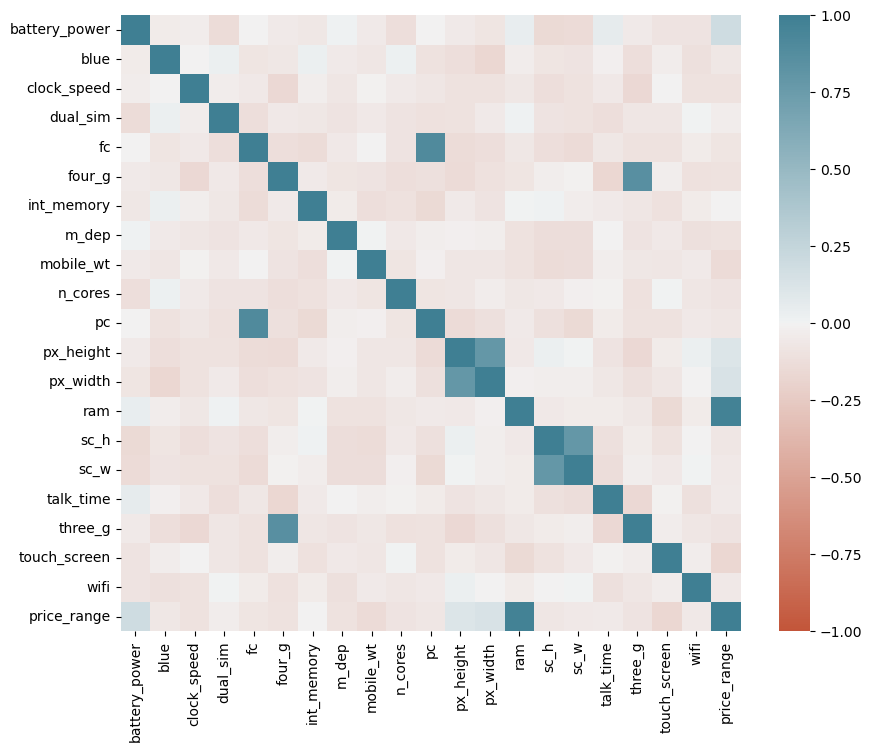

In [61]:
data_mobi_corr = data_mobi.corr()
sns.heatmap(data_mobi_corr.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True))

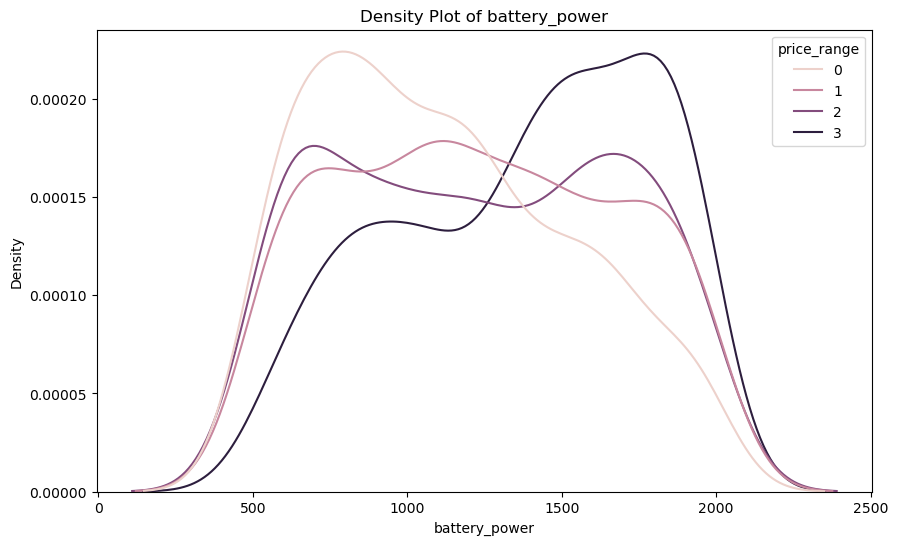

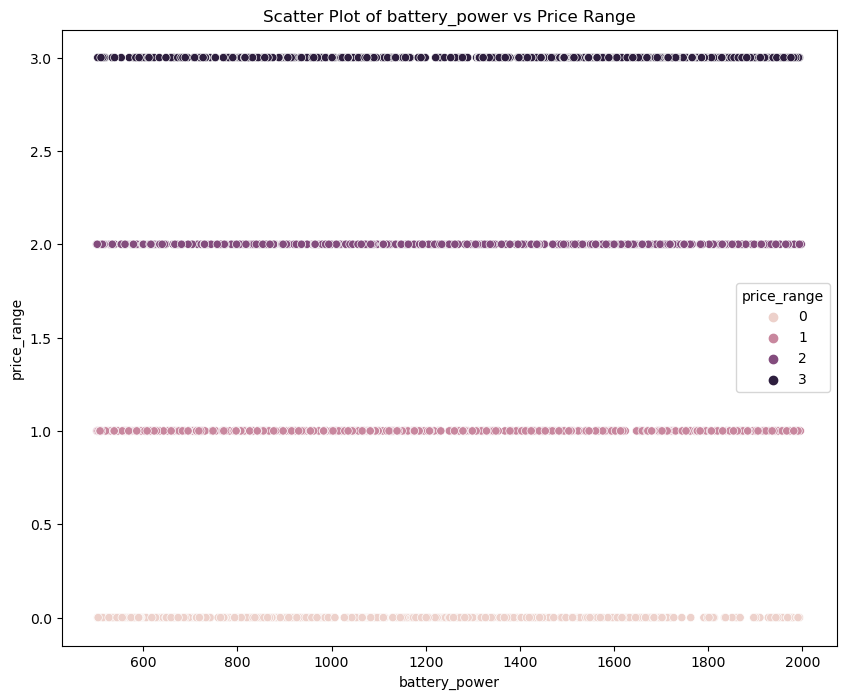

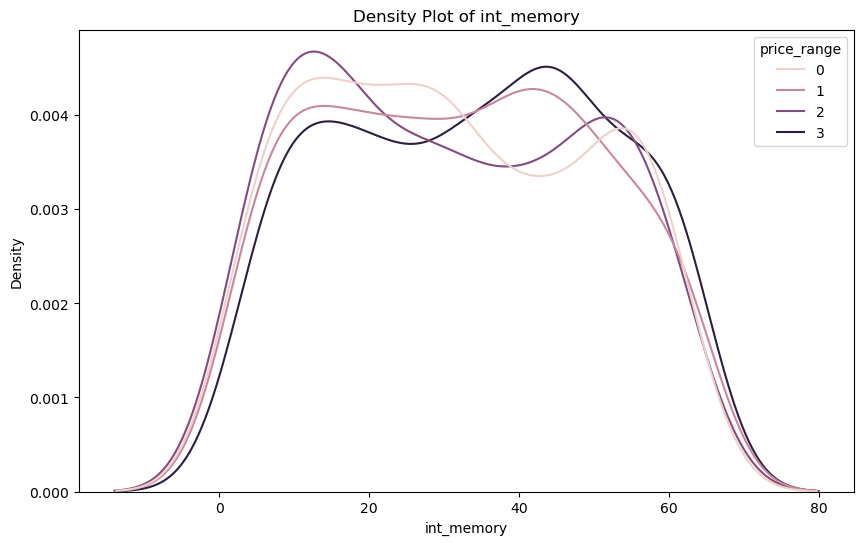

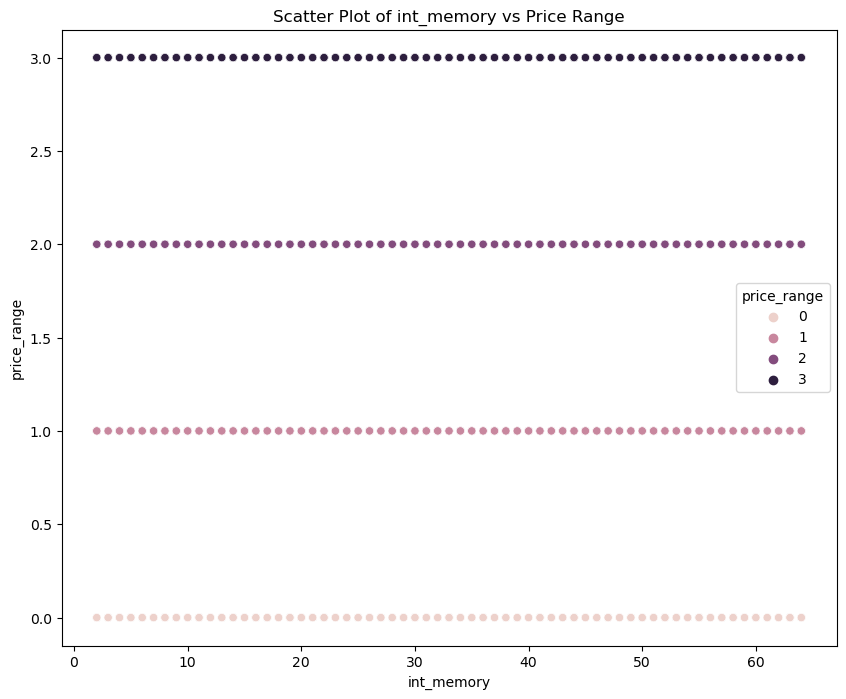

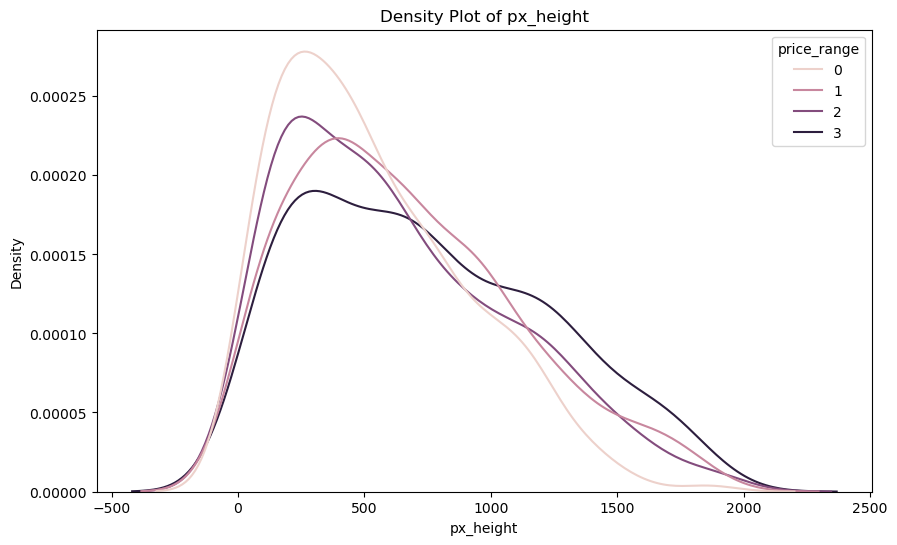

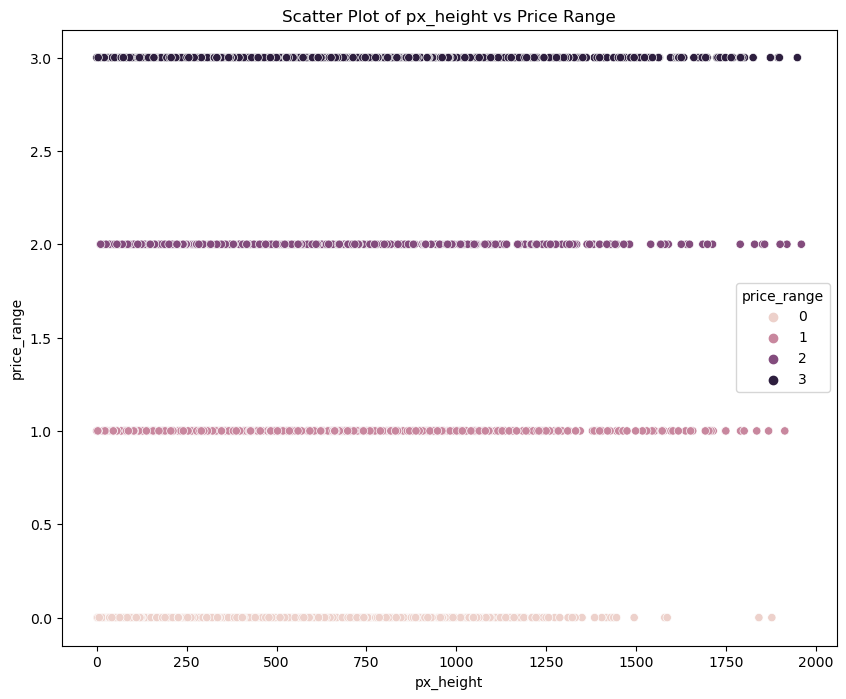

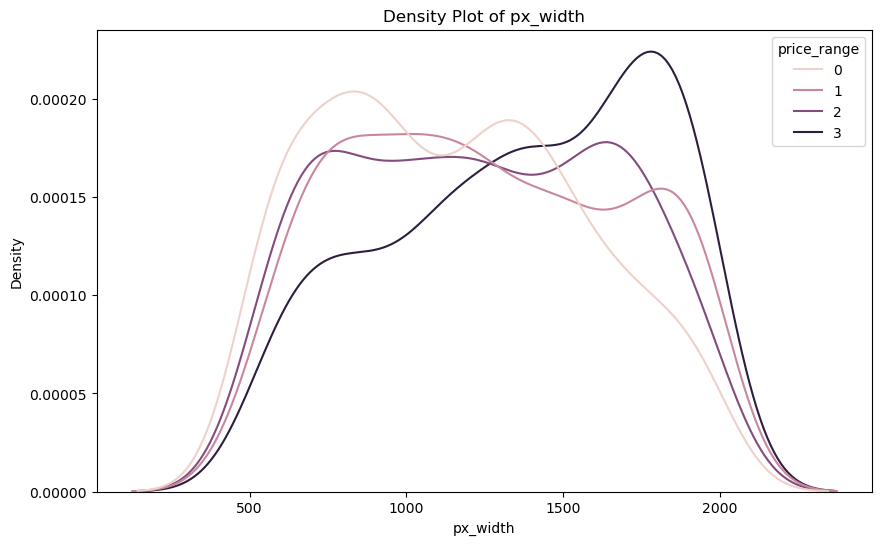

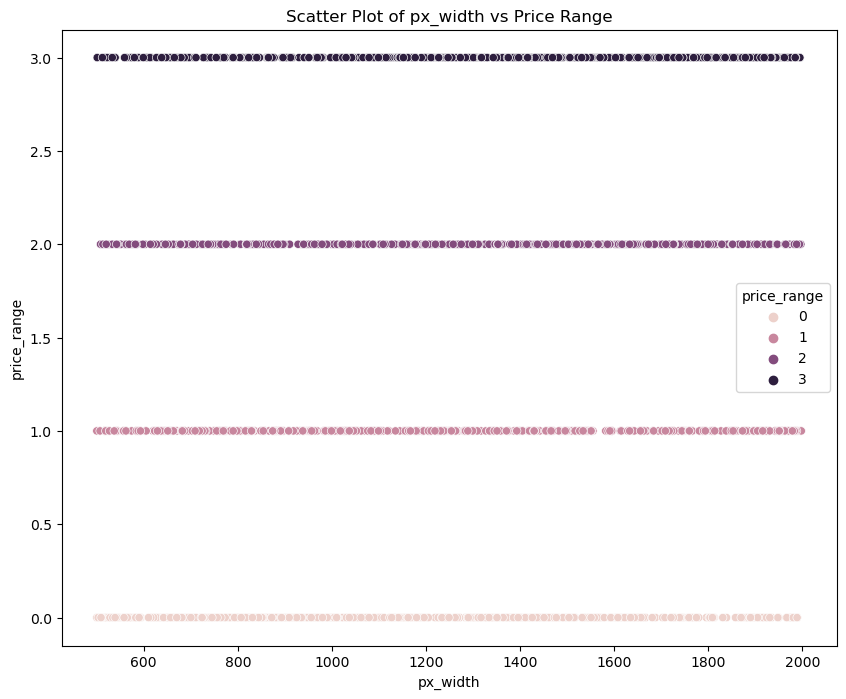

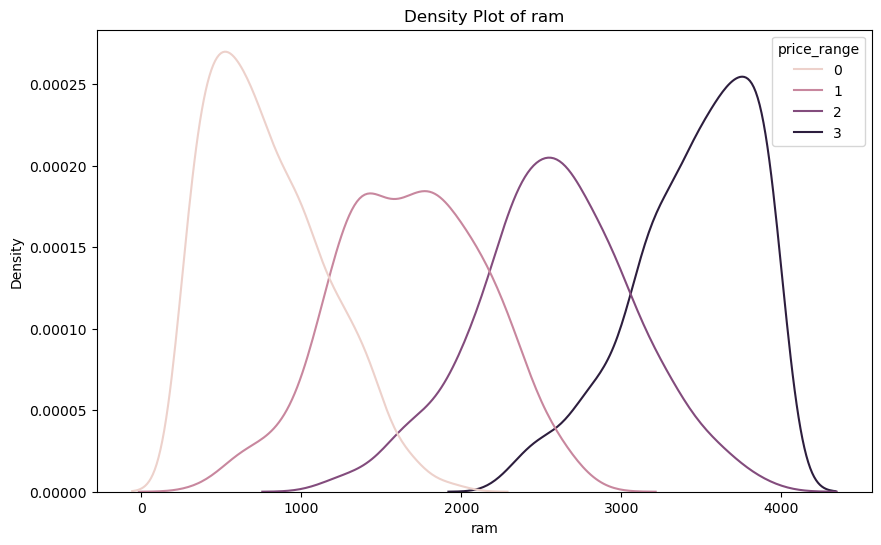

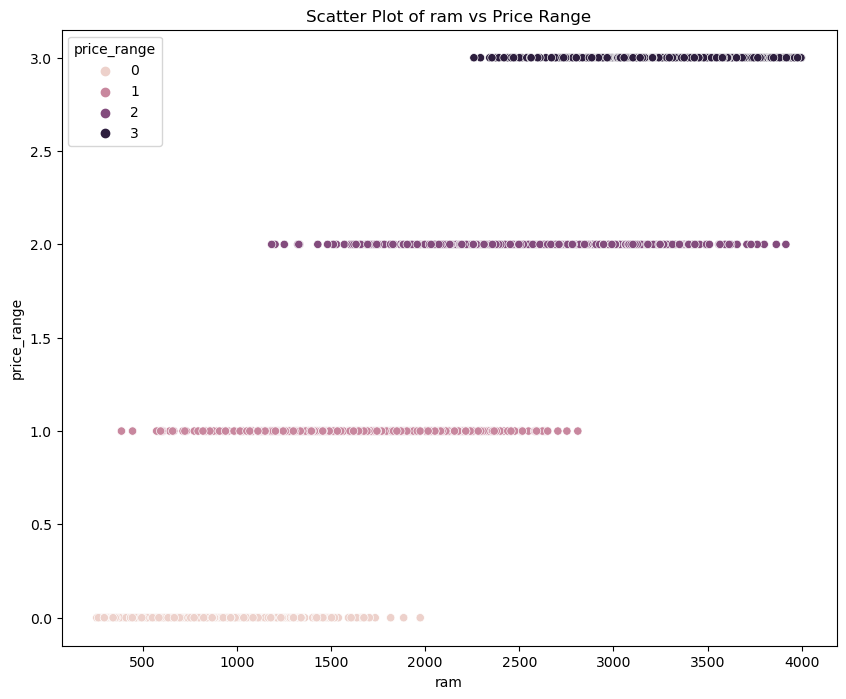

In [62]:
selected_features = ['battery_power','int_memory', 'px_height', 'px_width','ram']
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting densities and scatter plots for selected features
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data_mobi, x=feature, hue='price_range')
    plt.title(f'Density Plot of {feature}')
    plt.show()

    sns.scatterplot(data=data_mobi, x=feature, y='price_range', hue='price_range')
    plt.title(f'Scatter Plot of {feature} vs Price Range')
    plt.show()

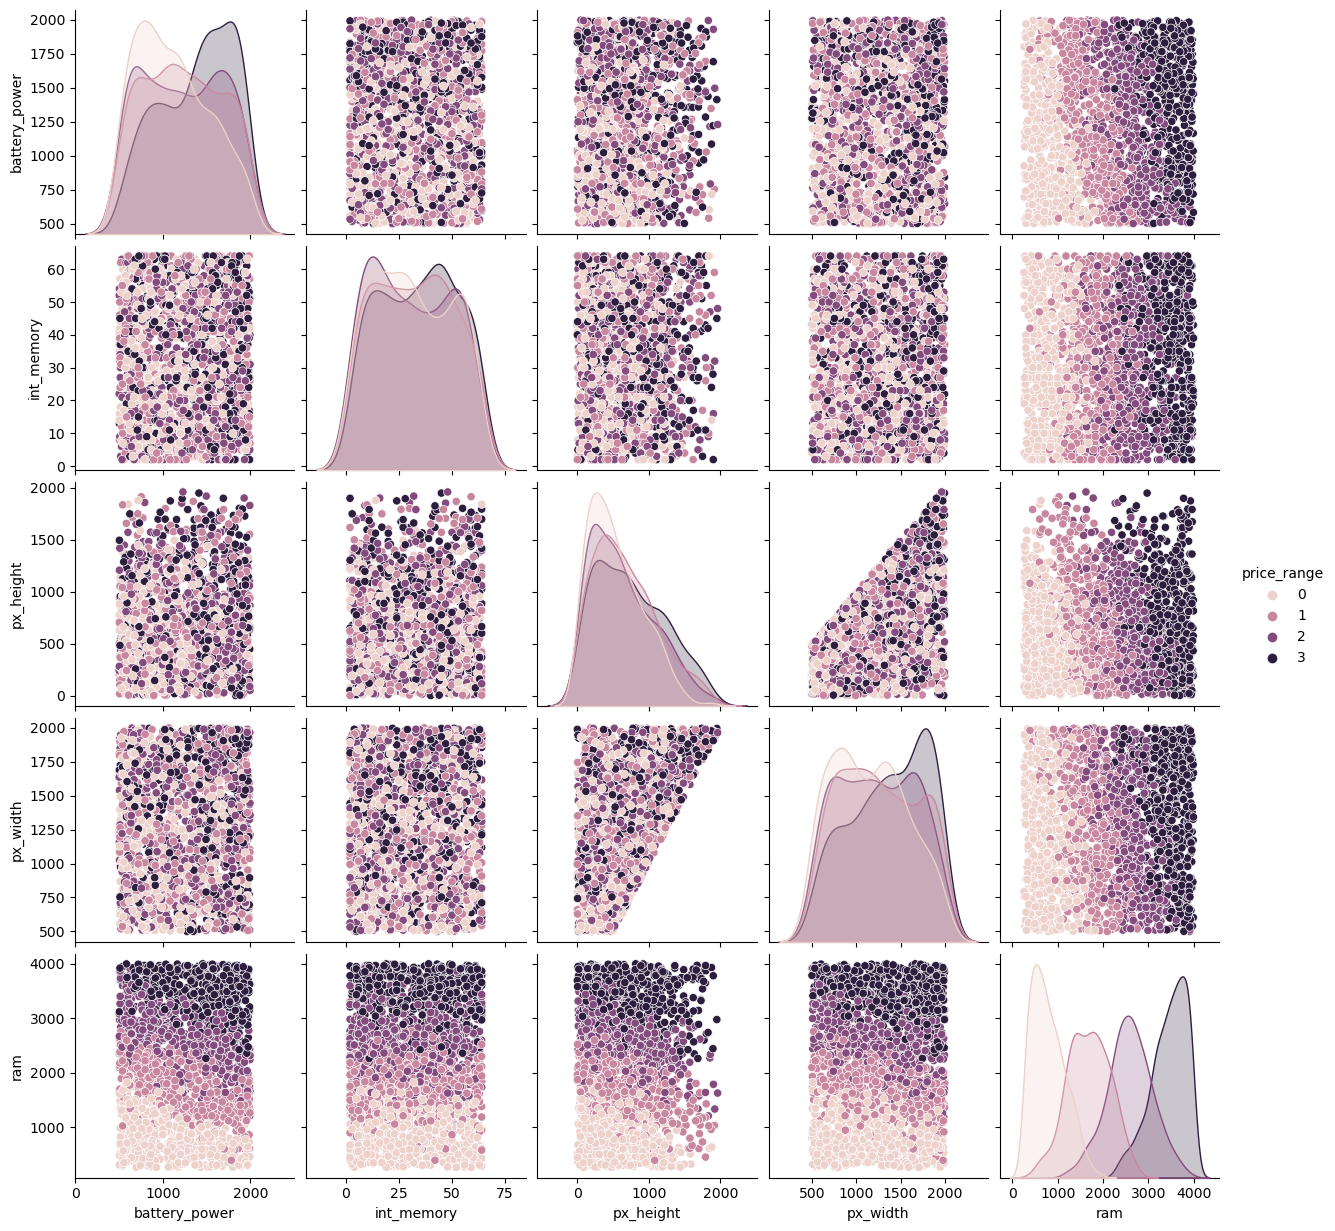

In [63]:
sns.pairplot(data= data_mobi, vars = selected_features,  hue='price_range')
plt.show()

c) Take the logarithm of base 10 of the following variables: battery power, int memory, px height, px width, mobile wt, ram, sc h, sc w, talk time. Explain what is the purpose of it and why is it a good idea.

In [64]:
log_transform_features = ['battery_power', 'int_memory', 'px_height', 'px_width', 'mobile_wt', 'ram', 'sc_h', 'sc_w', 'talk_time']
data_mobi_log = data_mobi.copy()

for feature in log_transform_features:
    data_mobi_log[feature] = np.log10(data_mobi_log[feature] + 1)  # Adding 1 to avoid log(0)

data_mobi_log.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,2.925828,0,2.2,0,1,0,0.903090,0.6,2.276462,2,...,1.322219,2.879096,3.406540,1.000000,0.903090,1.301030,0,0,1,1
1,3.009451,1,0.5,1,0,1,1.732394,0.7,2.136721,3,...,2.957128,3.298635,3.420286,1.255273,0.602060,0.903090,1,1,0,2
2,2.751279,1,0.5,1,2,1,1.623249,0.9,2.164353,5,...,3.101747,3.234770,3.415641,1.079181,0.477121,1.000000,1,1,0,2
3,2.789581,1,2.5,0,0,0,1.041393,0.8,2.120574,6,...,3.085291,3.252125,3.442480,1.230449,0.954243,1.079181,1,0,0,2
4,3.260548,1,1.2,0,13,1,1.653213,0.6,2.152288,2,...,3.082426,3.083861,3.149835,0.954243,0.477121,1.204120,1,1,0,1


d) Using 80% of the data, fit a multinomial logistic regression using the 5 features you selected in Exercise a) plus an intercept term. Note, if you didn’t select any of the features from Exercise c), make sure to include one of those features in your logistic regression model, i.e. 6 features in total and the intercept. Report the accuracy of the model in the remaining 20% data. 

In [65]:
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score


# Preparing data for training
x = data_mobi[selected_features]
y = data_mobi['price_range']

# Train-test split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=12345)  # coi lại dùng crosss_val_score để điều chỉnh bnh nn_split là phù hợp
for train_index, test_index in sss.split(x, y):
    x_tr, x_te = x.iloc[train_index], x.iloc[test_index]
    y_tr, y_te = y.iloc[train_index], y.iloc[test_index]

# Adding intercept
x_train = sm.add_constant(x_tr)
x_test = sm.add_constant(x_te)

# Fit the model
model = sm.MNLogit(y_tr, x_tr).fit()
print(model.summary())

# Predict and calculate accuracy
y_pred = model.predict(x_te).idxmax(axis=1)
accuracy = accuracy_score(y_te, y_pred)
print(f'Model Accuracy: {accuracy}')

Optimization terminated successfully.
         Current function value: 0.956877
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:            price_range   No. Observations:                 1600
Model:                        MNLogit   Df Residuals:                     1585
Method:                           MLE   Df Model:                           12
Date:                Thu, 23 May 2024   Pseudo R-squ.:                  0.3098
Time:                        23:53:13   Log-Likelihood:                -1531.0
converged:                       True   LL-Null:                       -2218.1
Covariance Type:            nonrobust   LLR p-value:                5.237e-287
price_range=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
battery_power    -0.0006      0.000     -3.788      0.000      -0.001      -0.000
int_memory       -0.

In [66]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Preparing data for training
x = data_mobi_log[selected_features]
y = data_mobi_log['price_range']

# Train-test split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=12345)
for train_index, test_index in sss.split(x, y):
    x_tr, x_te = x.iloc[train_index], x.iloc[test_index]
    y_tr, y_te = y.iloc[train_index], y.iloc[test_index]

# Adding intercept
x_tr = sm.add_constant(x_tr)
x_te = sm.add_constant(x_te)

# Fit the model
model = sm.MNLogit(y_tr, x_tr).fit()
print(model.summary())

# Predict and calculate accuracy
y_pred = model.predict(x_te).idxmax(axis=1)
accuracy = accuracy_score(y_te, y_pred)
print(f'Model Accuracy: {accuracy}')

Optimization terminated successfully.
         Current function value: 0.199177
         Iterations 13
                          MNLogit Regression Results                          
Dep. Variable:            price_range   No. Observations:                 1600
Model:                        MNLogit   Df Residuals:                     1582
Method:                           MLE   Df Model:                           15
Date:                Thu, 23 May 2024   Pseudo R-squ.:                  0.8563
Time:                        23:53:13   Log-Likelihood:                -318.68
converged:                       True   LL-Null:                       -2218.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
price_range=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -212.9832     21.772     -9.782      0.000    -255.656    -170.310
battery_power    18

e) Write down all model coefficient estimates together with their interpretation, i.e. what is the
relationship between the dependent variable and independent variables according to the estimates?


In [67]:
model.params

,0,1,2
const,-212.983240,-569.136559,-1008.394818
battery_power,18.748638,40.949491,62.623051
int_memory,1.072774,1.380483,2.136715
px_height,3.276274,7.301617,11.360323
px_width,13.611561,30.760714,45.174945
ram,33.896000,101.576172,192.697720


f) Use a 5-fold cross-validation approach using the same variables as in Exercise d) and report the average and standard deviation of the accuracy of the model.

In [68]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

x_cv = data_mobi_log[selected_features]
y_cv = data_mobi_log['price_range']
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

# Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Cross-validation
cv_scores = cross_val_score(log_reg, x_cv, y_cv, cv=kf)

print(f'Average Accuracy: {cv_scores.mean()}')
print(f'Std: {cv_scores.std()}')

Average Accuracy: 0.8734999999999999
Std: 0.00815475321515002


g) Discuss the main difference between the approaches in Exercises d) and f)

Answer in the Pdf. 

2 Neural networks and dimensionality reduction (40 pts.)

a) Use the same features you selected in the previous exercise and train all the architectures in Table 1
for a large number of epochs. Then show the plots of the (categorical) accuracy of the validation and
training data sets. Comment on the graphs and report the number of epochs you choose to train each
of the 6 architectures in Table 1. Use the categorical cross-entropy loss function to train all neural
networks. You should choose the rest of hyperparameters appropriately.

In [103]:
selected_features = ['battery_power', 'ram', 'px_height', 'px_width', 'int_memory']
# Preparing data for training
X_log = data_mobi_log[selected_features].values
y_log = data_mobi_log['price_range'].values

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [117]:
# One-hot encode the target variable
onehot_encoder = OneHotEncoder(sparse=False)
y_log = onehot_encoder.fit_transform(y_log.reshape (-1,1))

C:\Users\Taruna Manuja\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [105]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2,
                                                    random_state=12345)

In [106]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [107]:
 # Split the training set further into training and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.15,
                                                          random_state=12345)

In [108]:
# Define neural network architectures
architectures = [
    {'hidden_layers': 1, 'neurons': 5},
    {'hidden_layers': 1, 'neurons': 20},
    {'hidden_layers': 2, 'neurons': 5},
    {'hidden_layers': 2, 'neurons': 20},
    {'hidden_layers': 3, 'neurons': 5},
    {'hidden_layers': 3, 'neurons': 20}
]

In [109]:
# Function to create and train a neural network
def neural_network_model(hidden_layers, neurons, X_train, y_train, X_val,
                           y_val, epochs=100, batch_size = 32):
    #initiating neural network
    neuralnet = Sequential()
    #input layer
    neuralnet.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    #hidden layers
    for i in range(hidden_layers - 1):
        neuralnet.add(Dense(neurons, activation='relu'))
    #output layer
    neuralnet.add(Dense(y_train.shape[1], activation='softmax'))

    #compiling neural network
    neuralnet.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

    #fitting neural network
    history = neuralnet.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, verbose=0)
    return neuralnet, history

C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


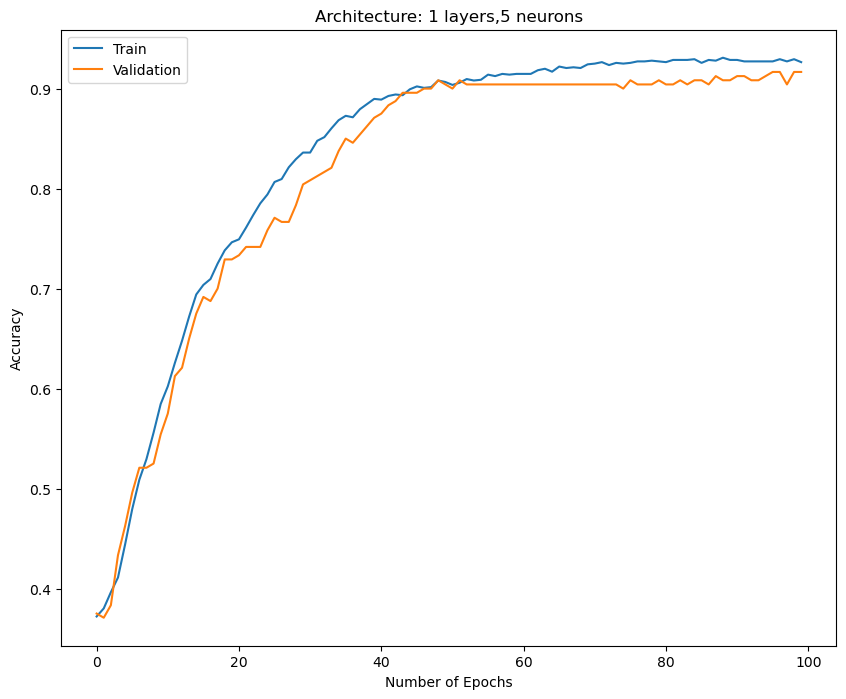

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


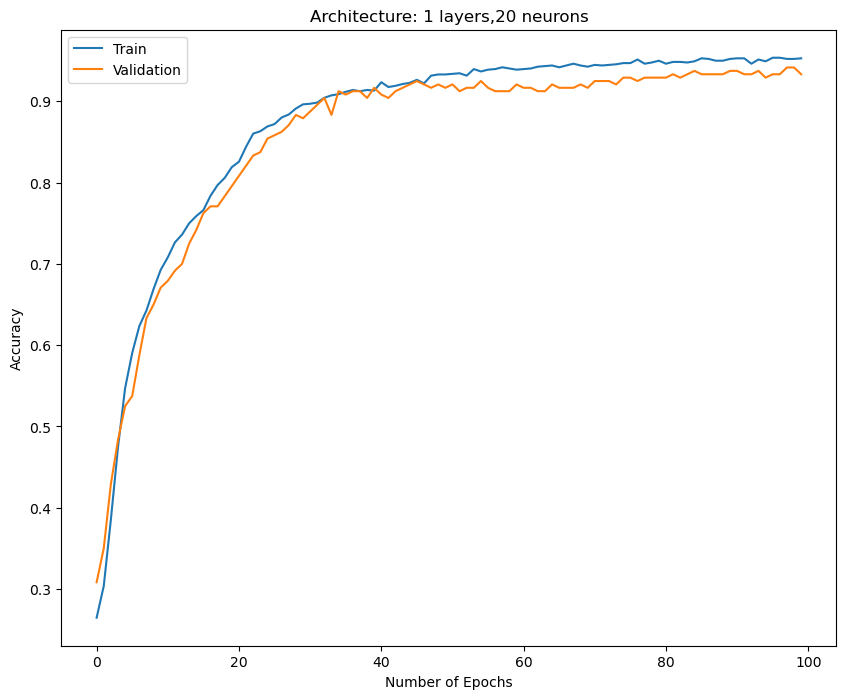

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


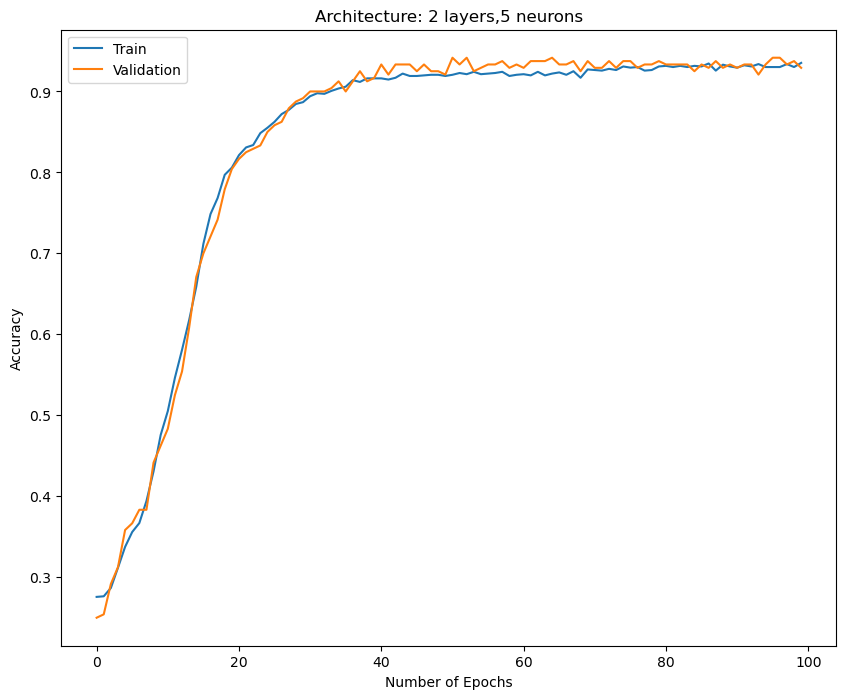

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


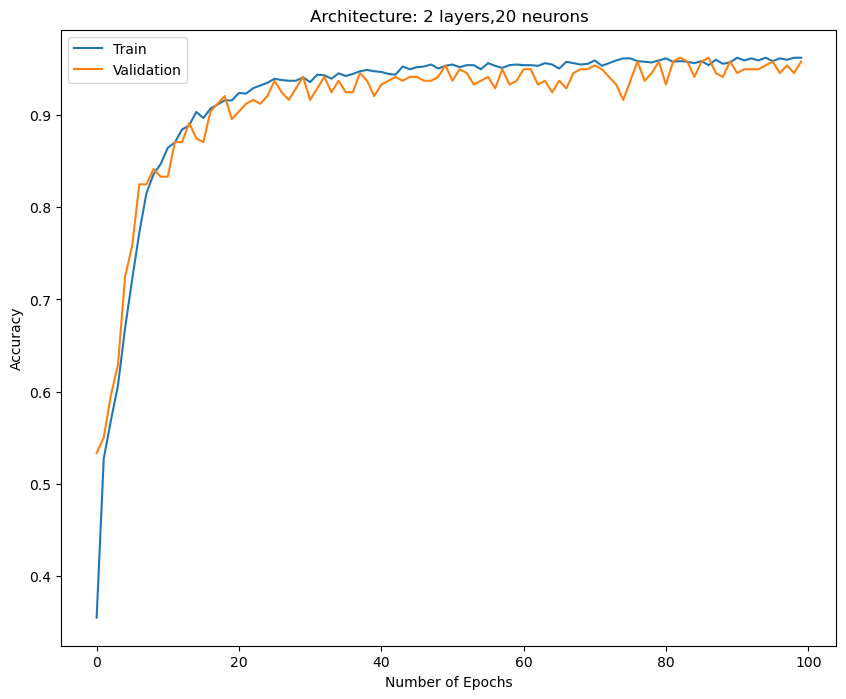

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


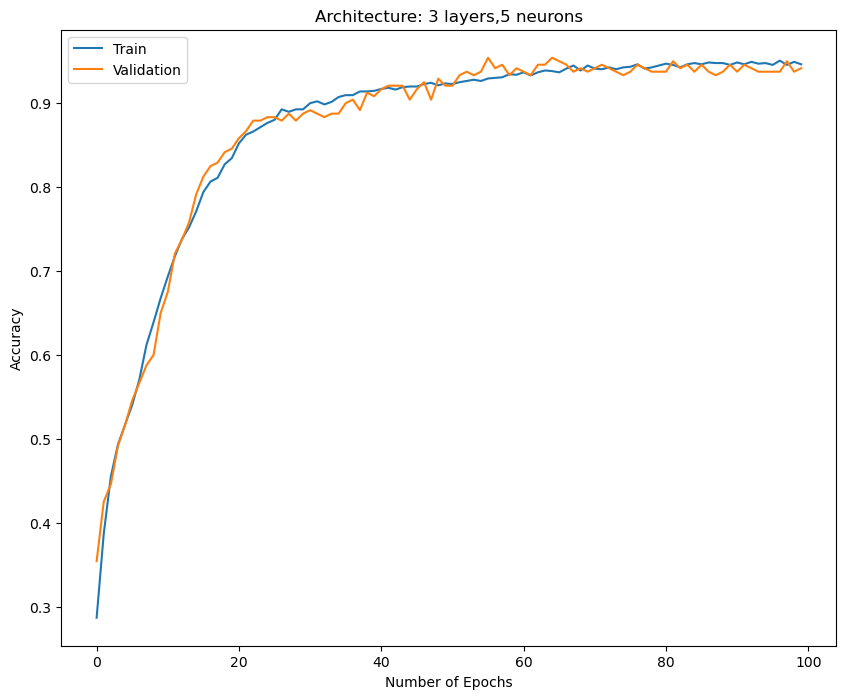

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


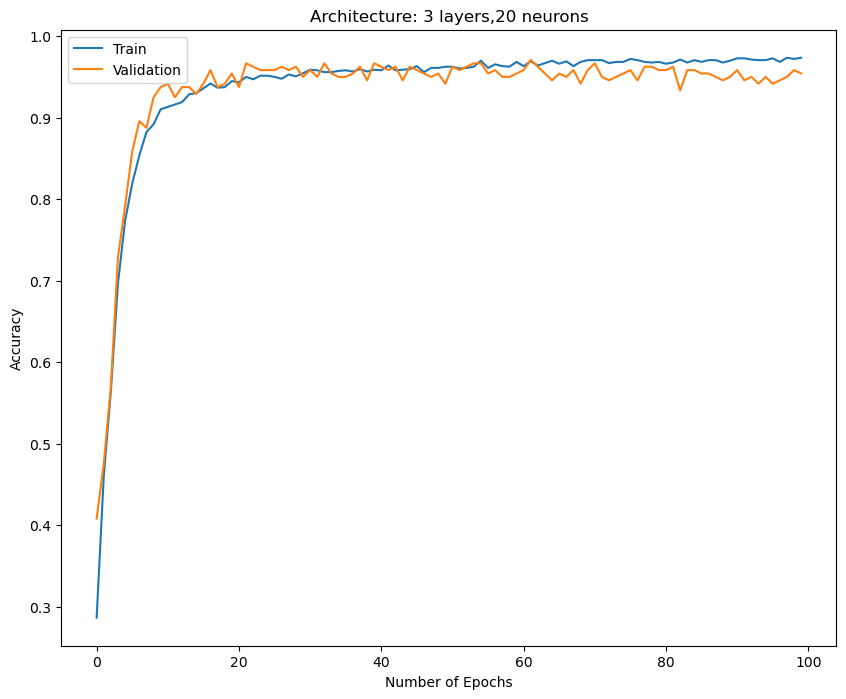

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [110]:
# Train and evaluate models
results = []
for arch in architectures:
    neuralnet, history = neural_network_model(arch['hidden_layers'],
                                              arch['neurons'],
                                              X_train_sub, y_train_sub,
                                              X_val, y_val, epochs = 100,
                                              batch_size =32)

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"Architecture: {arch['hidden_layers']} layers,{arch['neurons']} neurons")
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Make predictions on the test set
    y_pred_prob = neuralnet.predict(X_val)

    # Convert pseudoprobabilities to class labels
    y_pred_class = np.argmax(y_pred_prob, axis=1)
    y_test_class = np.argmax(y_val, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_class, y_pred_class)
    results.append((arch, test_accuracy))

b) Report the (categorical) accuracy in the test set for all architectures in Table 1.

In [119]:
# Print the test set accuracy for each architecture
for arch, accuracy in results:
    print(f"Architecture: {arch['hidden_layers']} layers, {arch['neurons']} neurons - Test Accuracy: {accuracy:.4f}")

Architecture: 1 layers, 5 neurons - Test Accuracy: 0.9167
Architecture: 1 layers, 20 neurons - Test Accuracy: 0.9333
Architecture: 2 layers, 5 neurons - Test Accuracy: 0.9292
Architecture: 2 layers, 20 neurons - Test Accuracy: 0.9583
Architecture: 3 layers, 5 neurons - Test Accuracy: 0.9417
Architecture: 3 layers, 20 neurons - Test Accuracy: 0.9542


c) Use principal component analysis (PCA) and find the transformations that preserve 20, 10, and 5
components. Make sure to use the original data, not the data where you use the log of base 10 and
selected only some features. How much variability of the original data do 20, 10, and 5 components
preserve?


In [112]:
# Select all features (excluding the target variable)
X_pca = data_mobi.drop('price_range', axis = 1).values
print(X_pca)

[[8.420e+02 0.000e+00 2.200e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [1.021e+03 1.000e+00 5.000e-01 ... 1.000e+00 1.000e+00 0.000e+00]
 [5.630e+02 1.000e+00 5.000e-01 ... 1.000e+00 1.000e+00 0.000e+00]
 ...
 [1.911e+03 0.000e+00 9.000e-01 ... 1.000e+00 1.000e+00 0.000e+00]
 [1.512e+03 0.000e+00 9.000e-01 ... 1.000e+00 1.000e+00 1.000e+00]
 [5.100e+02 1.000e+00 2.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]]


In [113]:
y_pca = to_categorical(data_mobi['price_range'])

In [114]:
# Split into training and testing sets
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca,
                                                    test_size=0.2,
                                                    random_state=12345)

In [115]:
# Perform PCA and preserve 20, 10, and 5 components
pca_components = [20, 10, 5]
pca_results = []
for n_components in pca_components:
    pca = PCA(n_components=n_components)
    X_pca_train_scaled = scaler.fit_transform(X_pca_train)
    X_pca_test_scaled = scaler.transform(X_pca_test)
    X_pca_train_transformed = pca.fit_transform(X_pca_train_scaled)
    X_pca_test_transformed = pca.transform(X_pca_test_scaled)
    
    variance_explained = np.sum(pca.explained_variance_ratio_)
    
    print(f"PCA with {n_components} components preserves {variance_explained:.4f} of the variance")

    # Train and evaluate models with PCA-transformed data
    for arch in architectures:
        X_train_sub_pca, X_val_pca, y_train_sub_pca, y_val_pca = train_test_split(X_pca_train_transformed, y_pca_train, test_size=0.15, random_state=12345)
        
        model, history = neural_network_model(arch['hidden_layers'], arch['neurons'], X_train_sub_pca, y_train_sub_pca, X_val_pca, y_val_pca)

        # Evaluate on test set
        _, test_accuracy = model.evaluate(X_pca_test_transformed, y_test, verbose=0)
        pca_results.append((n_components, arch, test_accuracy))

PCA with 20 components preserves 1.0000 of the variance


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PCA with 10 components preserves 0.6340 of the variance


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PCA with 5 components preserves 0.3725 of the variance


C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


d) With each of the 3 data transformations of exercise c), train the 6 architectures in Table 1. Report the
(categorical) accuracy in the test set for the 18 different runs. 

In [116]:
# Print the test set accuracy for PCA-transformed data
for n_components, arch, accuracy in pca_results:
    print(f"PCA: {n_components} components, Architecture: {arch['hidden_layers']} layers, {arch['neurons']} neurons - Test Accuracy: {accuracy:.4f}")

PCA: 20 components, Architecture: 1 layers, 5 neurons - Test Accuracy: 0.9550
PCA: 20 components, Architecture: 1 layers, 20 neurons - Test Accuracy: 0.9050
PCA: 20 components, Architecture: 2 layers, 5 neurons - Test Accuracy: 0.9625
PCA: 20 components, Architecture: 2 layers, 20 neurons - Test Accuracy: 0.9300
PCA: 20 components, Architecture: 3 layers, 5 neurons - Test Accuracy: 0.9625
PCA: 20 components, Architecture: 3 layers, 20 neurons - Test Accuracy: 0.8950
PCA: 10 components, Architecture: 1 layers, 5 neurons - Test Accuracy: 0.4950
PCA: 10 components, Architecture: 1 layers, 20 neurons - Test Accuracy: 0.4625
PCA: 10 components, Architecture: 2 layers, 5 neurons - Test Accuracy: 0.5100
PCA: 10 components, Architecture: 2 layers, 20 neurons - Test Accuracy: 0.4900
PCA: 10 components, Architecture: 3 layers, 5 neurons - Test Accuracy: 0.4675
PCA: 10 components, Architecture: 3 layers, 20 neurons - Test Accuracy: 0.4850
PCA: 5 components, Architecture: 1 layers, 5 neurons - Tes

e) List the total number of weights for each of the 18 different trained neural networks

In [120]:
# Calculate and report the total number of weights for each trained neural network
def calculate_total_weights(model):
    total_weights = 0
    for layer in model.layers:
        layer_weights = layer.get_weights()[0].size
        total_weights += layer_weights
    return total_weights

weights_results = []
for arch in architectures:
    X_train_sub_pca, X_val_pca, y_train_sub_pca, y_val_pca = train_test_split(X_pca_train_scaled,
                                                                          y_train,
                                                                          test_size=0.15,
                                                                          random_state=12345)
    model, _ = neural_network_model(arch['hidden_layers'], arch['neurons'], X_train_sub_pca, y_train_sub_pca, X_val_pca, y_val_pca, epochs=1)
    total_weights = calculate_total_weights(model)
    weights_results.append((arch, total_weights))

C:\Users\Taruna Manuja\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [121]:
# Print the total number of weights for each architecture
for arch, total_weights in weights_results:
    print(f"Architecture: {arch['hidden_layers']} layers, {arch['neurons']} neurons - Total Weights: {total_weights}")

Architecture: 1 layers, 5 neurons - Total Weights: 120
Architecture: 1 layers, 20 neurons - Total Weights: 480
Architecture: 2 layers, 5 neurons - Total Weights: 145
Architecture: 2 layers, 20 neurons - Total Weights: 880
Architecture: 3 layers, 5 neurons - Total Weights: 170
Architecture: 3 layers, 20 neurons - Total Weights: 1280
